In [ ]:
!pip install -U scikit-fuzzy

     |████████████████████████████████| 1.0MB 6.5MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=6c1a2fdd8451b063fb0693415b4c29a54bf4b4560fb3aadd8dd2203f8f811ea9
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

## I. Calculation of net income


###1. Helper class / Child Cost by age


We will consider the following intervals:
1. From 0 to 2 years old: 400dt / month
2. From 2 to 6 years old: 300dt / month
3. From 6 to 18 years old: 250dt / month
4. From 18 to 23 years old: 600dt / month

I chose these values ​​taking into consideration tunisian life expenses, for example a young person between 18 and 23 who is very probably a student needs on average 600dt from his parents to cover his needs


In [ ]:
class Switch(dict):
    def __getitem__(self, item):
        for key in self.keys():                   # iterate over the intervals
            if item in key:                       # if the argument is part of that interval
                return super().__getitem__(key)   # return its associated value
        raise KeyError(item)                      # if not in any interval, raise KeyError

In [ ]:
  #cost of a child by age in months
  switch = Switch({
    range(0, 24): 4.8, 
    range(24, 72): 3.6,
    range (72,216): 3, 
    range (216, 276):7.2 
})

###Net income calculation function

In [ ]:
def calcul_net_revenue(ages, marital_status, annual_revenue, rent, other_annual_revenues):
  '''

we will consider that:
  - ages:
    it is a list containing the ages of the children
  - marital_status:
    if married: we double the salary by considering that the two partners share all his income and expenses
    if divorced we will add 0.3 * salary considering that the ex-partner will help with this sum
    if widowed / single: we add / sibstitute nothing
  - rent: we sibstitute this sum
  - other annual revenues: we add this amount

  '''
  
  cost = 0;
  child_cost = 0
  for child_age in ages:
    #convert child_age to months and get the cost
    child_cost = switch[child_age*12]
    print ('child age : ',child_age , 'child cost :' ,child_cost)
    cost = cost + child_cost
    

  if (marital_status == "maried"):
    annual_revenue = annual_revenue*2

  elif (marital_status == "divorced"):
    annual_revenue = annual_revenue+0.3*annual_revenue

  net_revenue = annual_revenue + other_annual_revenues - cost
  return (net_revenue)

## II. Environmental factors - Fuzzy Logic

### Antecedents et Consequents
We start first by defining the antecedents and consequences of our Fuzzy logic

In [ ]:
#### Antecedents
#the age is located in an interval of 18 to 90 cut in steps of 1
age = ctrl.Antecedent(np.arange(18,90,1), 'age')

#we will detail how we will cut its intervals
employment_status = ctrl.Antecedent(np.arange(0,100,1), 'employment_status')

# seniority in the current job is in a range of 0 to 360 coupé par pas de 1 (en mois)
seniority = ctrl.Antecedent(np.arange(0,360,1), 'seniority')

#we will detail how we will cut its intervals
accomodation_situation = ctrl.Antecedent(np.arange(0,100,1), 'accomodation_situation')

#occupation period of current accommodation is in a range of 0 to 360 
accomodation_period = ctrl.Antecedent(np.arange(0,360,1), 'accomodation_period')

# existence of other credits, we will detail how we will cut its intervals
other_credits = ctrl.Antecedent(np.arange(0,100,1), 'other_credits')


####Consequent

#Result that we want to determine first: the state of the environment (favorable or not)
#we will detail how we will cut its intervals
env_factors = ctrl.Consequent(np.arange(0,100,1), 'env_factors')



### Intervales

we then define the intervals used in the antecedents and the consequents.
For example,
- age will be split into 'pre-adult', 'adult' and 'aged'

We will then give the membership curves at these intervals:

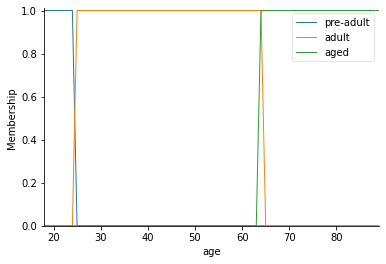

In [ ]:
# pre-adult: (from 18 to 24), adult = (from 25 to 64) and aged from 65
#a trapezoidal curve, pre-adult = 1 until 24, pre-adult = 0 from 25
pre_adult = fuzz.trapmf(age.universe, [18, 18, 24,25])

adult = fuzz.trapmf(age.universe, [25, 25, 64,64])

aged = fuzz.trapmf(age.universe, [64, 64, 90,90])

age['pre-adult'] = pre_adult
age['adult'] = adult
age['aged'] = aged

age.view()

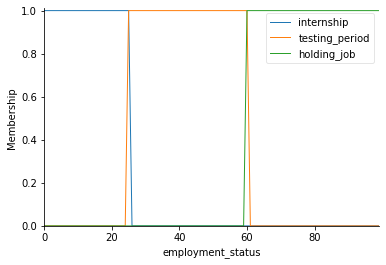

In [ ]:
internship = fuzz.trapmf(employment_status.universe, [0, 0, 25, 25])
testing_period = fuzz.trapmf(employment_status.universe, [25, 25, 60, 60])
holding_job = fuzz.trapmf(employment_status.universe, [60, 60, 100, 100])

employment_status['internship'] = internship
employment_status['testing_period'] = testing_period
employment_status['holding_job'] = holding_job

employment_status.view()

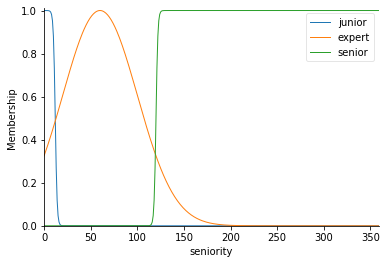

In [ ]:
junior = fuzz.sigmf(seniority.universe, 12,-1)
expert = fuzz.gaussmf(seniority.universe, 60,40)
senior = fuzz.sigmf(seniority.universe,120, 1)

seniority['junior'] = junior 
seniority['expert'] = expert
seniority['senior'] = senior

seniority.view()

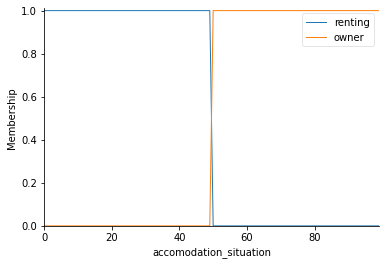

In [ ]:
renting = fuzz.trapmf(accomodation_situation.universe, [0, 0, 49,49])
owner = fuzz.trapmf(accomodation_situation.universe, [50, 50, 100,100])
accomodation_situation['renting'] = renting
accomodation_situation['owner'] = owner

accomodation_situation.view()

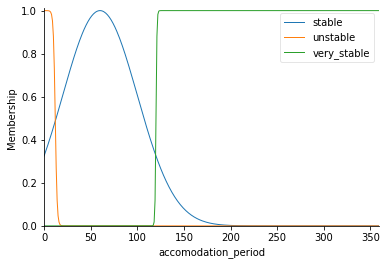

In [ ]:
unstable = fuzz.sigmf(accomodation_period.universe, 12,-1)
stable = fuzz.gaussmf(accomodation_period.universe, 60,40)
very_stable = fuzz.sigmf(accomodation_period.universe,120, 2)

accomodation_period['stable'] = stable 
accomodation_period['unstable'] = unstable
accomodation_period['very_stable'] = very_stable

accomodation_period.view()

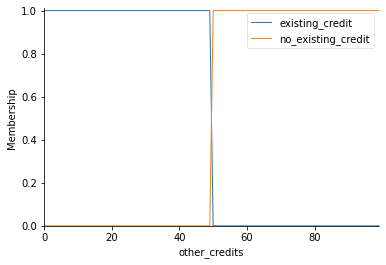

In [ ]:
existing_credit = fuzz.trapmf(other_credits.universe, [0, 0, 49,49])
no_existing_credit = fuzz.trapmf(other_credits.universe, [50, 50, 100,100])

other_credits['existing_credit'] = existing_credit
other_credits['no_existing_credit'] = no_existing_credit

other_credits.view()

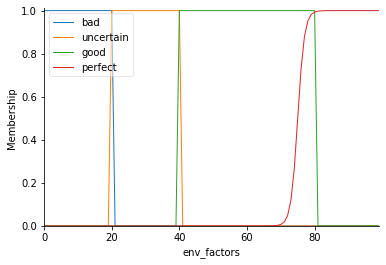

In [ ]:
bad = fuzz.trapmf(env_factors.universe, [0,0,20,20])
uncertain = fuzz.trapmf(env_factors.universe, [20,20,40,40])
good = fuzz.trapmf(env_factors.universe, [40,40,80,80])
perfect = fuzz.sigmf(env_factors.universe, 75,1)

env_factors['bad'] = bad
env_factors['uncertain'] = uncertain
env_factors['good'] = good
env_factors['perfect'] = perfect

env_factors.view()

###Rules definition

In [ ]:
#the ideal case: the customer has very favorable environmental factors
rule1 = ctrl.Rule( (age['adult'] & employment_status['holding_job'] & seniority['expert'] &
                    accomodation_situation['owner'] & other_credits['no_existing_credit']&
                    (accomodation_period['stable'] | accomodation_period['very_stable']) )
                    , env_factors['perfect'])

In [ ]:
# if the client has a permanent job, owns his home and has no other credits, these are good factors
rule2 = ctrl.Rule ((employment_status['holding_job'] & accomodation_situation['owner'] 
                    & other_credits['no_existing_credit']),
                   env_factors['good'])

In [ ]:
#even if the client is in the test period, the fact that he is pre-adult and has no other credits plays 
#an important role since he will certainly have a higher salary in the next few years
rule3 = ctrl.Rule ((age['pre-adult'] & employment_status['testing_period']  & other_credits['no_existing_credit']),
                   env_factors['good'])

In [ ]:

# if the client is in a test period and already has other credits, it will weigh
# heavily for him since his salary will not be as important to cover all his needs
rule4 = ctrl.Rule ((employment_status['testing_period']  & other_credits['existing_credit'] & seniority['junior'] ),
                   env_factors['bad'])

In [ ]:

# if the client is well aged and already has other credits, 
#it will lower the chances of him repaying his debts
rule5 = ctrl.Rule ((age['aged']  & other_credits['existing_credit'] & accomodation_situation['renting'] ),
                   env_factors['bad'])

In [ ]:
# the client having an internship and renting his accommodation => bad factors
rule6 = ctrl.Rule ((employment_status['internship'] & accomodation_situation['renting'] ),
                   env_factors['bad'])

In [ ]:

# if the client is renting and is not stable in his rental, having more other 
#credits, this will affect his ability to repay debts, his environment is unfavorable
rule7 = ctrl.Rule ((employment_status['holding_job'] & accomodation_situation['renting'] & accomodation_period['unstable']
                    & other_credits['existing_credit']),
                   env_factors['bad'])

In [ ]:
rule8 = ctrl.Rule ((age['adult']  & other_credits['existing_credit'] & accomodation_situation['owner'] &
                   employment_status['holding_job'] & seniority['expert'] ),
                   env_factors['uncertain'])

###Simulation

In [ ]:
#we compile the rules
credit_scoring_rules = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])
env_simulation = ctrl.ControlSystemSimulation(credit_scoring_rules)

In [ ]:

#Simulation
'''

We test rule3
pre-adult age => value in the interval [18-24]
employment_status: testing_period => value in the range [25-60]
 other_credits: no_existing_credit => value in the range [50-100]

We then want to obtain a result between 40 and 80 indicating that the environment is good

'''
env_simulation.input['age'] = 23
env_simulation.input['employment_status'] = 30
env_simulation.input['seniority'] = 60
env_simulation.input['accomodation_situation'] = 60
env_simulation.input['accomodation_period'] = 10
env_simulation.input['other_credits'] = 60

env_simulation.compute()

pred = env_simulation.output['env_factors']
pred

59.999999999999986

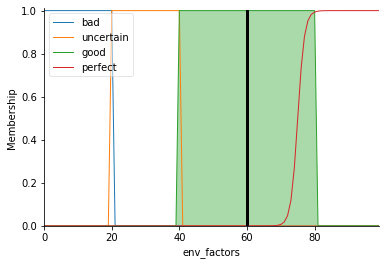

In [ ]:
env_factors.view(sim=env_simulation)

## III. Credit Scoring - Fuzzy Logic


After having defined the function which will give us the net annual income of the client and predicted the state of the environment (bad / uncertain / good / perfect), we will use these two factors as input and add the annual slice of the requested credit to finally determine if it is a bad, uncertain or good client

In [ ]:
#the net annual income will be calculated from other data such as children's ages, marital status ...
net_annual_revenue = ctrl.Antecedent(np.arange(0,500,10), 'net_annual_revenue')

#annual_slice : of the requested credit
#it's usually 33% to 45% of net income
credit_slice = ctrl.Antecedent(np.arange(10,225,10), 'credit_slice')

#environment : the result of the precedent algorithm (env_factors)
environment = ctrl.Antecedent(np.arange(0,100,1), 'environment')


####Consequent
client_status = ctrl.Consequent(np.arange(0,100,1), 'client_status')

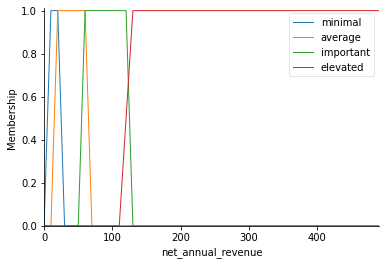

In [ ]:
minimal = fuzz.trapmf(net_annual_revenue.universe, [5,10,20,20] )
average = fuzz.trapmf(net_annual_revenue.universe, [20,20,60,60])
important = fuzz.trapmf(net_annual_revenue.universe,[60,60,120,120])
elevated = fuzz.sigmf(net_annual_revenue.universe,120,1)

net_annual_revenue['minimal'] = minimal 
net_annual_revenue['average'] = average
net_annual_revenue['important'] = important
net_annual_revenue['elevated'] = elevated

net_annual_revenue.view()

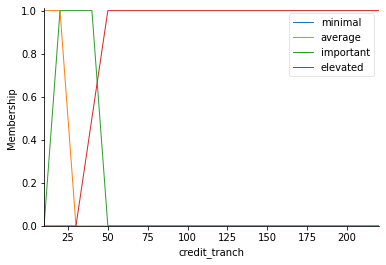

In [ ]:
minimal = fuzz.trapmf(credit_slice.universe, [1.5,1.8,7,7])
average = fuzz.trapmf(credit_slice.universe, [7,7,20,20])
important = fuzz.trapmf(credit_slice.universe,[20,20, 40, 40])
elevated = fuzz.sigmf(credit_slice.universe, 40,1)

credit_slice['minimal'] = minimal 
credit_slice['average'] = average
credit_slice['important'] = important
credit_slice['elevated'] = elevated

credit_slice.view()


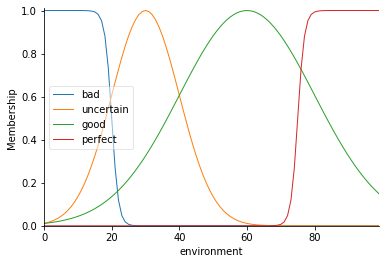

In [ ]:
bad = fuzz.sigmf(environment.universe, 20, -1)
uncertain = fuzz.gaussmf(environment.universe, 30,10)
good = fuzz.gaussmf(environment.universe, 60,20)
perfect = fuzz.sigmf(environment.universe, 75,1)

environment['bad'] = bad
environment['uncertain'] = uncertain
environment['good'] = good
environment['perfect'] = perfect

environment.view()

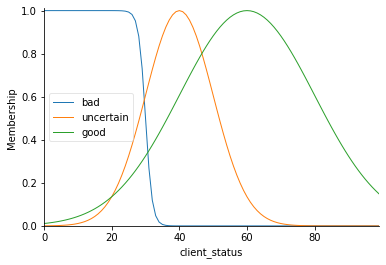

In [ ]:
bad = fuzz.sigmf(client_status.universe, 30, -1)
uncertain = fuzz.gaussmf(client_status.universe, 40,10)
good = fuzz.gaussmf(client_status.universe, 60,20)

client_status['bad'] = bad
client_status['uncertain'] = uncertain
client_status['good'] = good

client_status.view()

###Rules

In [ ]:

# if the client has a large net annual income,
# the slice may be about 33% of income or less, in which case he is a good client
rule9 = ctrl.Rule ((net_annual_revenue['important'] & (credit_slice['minimal'] | 
                                                      credit_slice['average']  )),
                   client_status['good'])
#if the client's income is large and the slice is large:
# 1st case: favorable environment => good client
rule10 = ctrl.Rule ((net_annual_revenue['important'] & credit_slice['important'] 
                     & (environment['good'] | environment['perfect'])),
                   client_status['good'])

# 2nd case: uncertain environment  => uncertain client 
rule11 = ctrl.Rule ((net_annual_revenue['important'] & credit_slice['important'] 
                     & environment['uncertain'] ),
                   client_status['uncertain'])

#3rd case : bad environment => bad client 
rule12 = ctrl.Rule ((net_annual_revenue['important'] & credit_slice['important'] 
                     & environment['bad'] ),
                   client_status['bad'])



In [ ]:

# if the client's income is important and the slice is elevated he will be a bad client
rule13 = ctrl.Rule ((net_annual_revenue['important'] & credit_slice['elevated']),
                   client_status['bad'])


In [ ]:

#if the client's income is elevated:
# 1st case: the slice is elevated: this client is uncertain: even if the environment is perfect;
# there is a large margin of error since we do not have
#the exact percentage of credit in relation to income
rule14 = ctrl.Rule ((net_annual_revenue['elevated'] & credit_slice['elevated']),
                   client_status['uncertain'])


# 2nd case: and the slice is important: you need a not bad environment
rule15 = ctrl.Rule ((net_annual_revenue['elevated'] & credit_slice['important'] 
                     & (~environment['bad'] )),
                   client_status['good'])

# 3rd case: minimal slice / average => good client (whatever the state of the environment)
rule16 = ctrl.Rule ((net_annual_revenue['elevated'] & (credit_slice['minimal']
                                                            |credit_slice['average'])),
                   client_status['good'])

In [ ]:

#if the client's income is average:
# 1st case: the slice is important or elevated => bad customer
rule17 = ctrl.Rule ((net_annual_revenue['average'] & (credit_slice['important']
                                                   |credit_slice['elevated'])),
                   client_status['bad'])


# 2nd case: the slice is average: you need a good / perfect environment for it to be a good client
rule18 = ctrl.Rule ((net_annual_revenue['average'] & credit_slice['average'] 
                     & (environment['good'] | environment['perfect'])),
                   client_status['good'])


# 3rd case: range average & uncertain environment  => uncertain client 
rule19 = ctrl.Rule ((net_annual_revenue['average'] & credit_slice['average']
                     & environment['uncertain']),
                   client_status['uncertain'])

#3eme cas : minimal slice & bad environment  => uncertain client 
rule20 = ctrl.Rule ((net_annual_revenue['average'] & credit_slice['minimal']
                     & environment['bad']),
                   client_status['uncertain'])

#4eme cas :  minimal slice & not bad environment  => good client  
rule21 = ctrl.Rule ((net_annual_revenue['average'] & credit_slice['minimal']
                     & (~environment['bad'])),
                   client_status['good'])


In [ ]:
#if the client's income is minimum:
# 1st case: the slice is minimum and the environment is good / perfect => good client
rule22 = ctrl.Rule ((net_annual_revenue['minimal'] & credit_slice['minimal']
                     &(environment['good'] | environment['perfect'] )),
                   client_status['good'])


# 2nd case: the slice is minimum and the environment is bad / uncertain => uncertain client 
rule23 = ctrl.Rule ((net_annual_revenue['minimal'] & credit_slice['minimal'] 
                     & (environment['bad'] | environment['uncertain'])),
                   client_status['uncertain'])

#3rd case : slice is average/important/elevated => bad client (whatever the environment state is)
rule24 = ctrl.Rule ((net_annual_revenue['minimal'] & (credit_slice['elevated']
                                                     |credit_slice['important']
                                                      |credit_slice['average'])),
                   client_status['bad'])

## IV. Simulation 




In [ ]:
'''

We test rule10
net_annual_revenue: important => value in the range [60-120]
credit_slice: important => value in the range [20-40]
environment: good (we already had in the previous simulation))

We then want to obtain a result that it is a good customer

'''

#the inputs we will use:
#1. 
annual_credit_slice = 30
#2. Calcul du revenu annuel net
ages = [12,20]
marital_status = "divorced"
annual_revenue = 80
rent=0
other_annual_revenues = 20


net_revenue = calcul_net_revenue(ages, marital_status, annual_revenue, rent, other_annual_revenues)
net_revenue


child age :  12 child cost : 3
child age :  20 child cost : 7.2


113.8

In [ ]:
# 3. we get the prediction we have already made
test_environment = pred
test_environment

59.999999999999986

In [ ]:
#we compile the rules
scoring_rules = ctrl.ControlSystem([rule9, rule10, rule11, rule12, rule13, rule14, rule15, rule17,
                                    rule18, rule19, rule20, rule21, rule22, rule23, rule24])

simulation = ctrl.ControlSystemSimulation(scoring_rules)

#Simulation
simulation.input['net_annual_revenue'] = net_revenue
simulation.input['credit_slice'] = annual_credit_slice
simulation.input['environment'] = test_environment
simulation.compute()

print(simulation.output['client_status'])

58.865133305688026


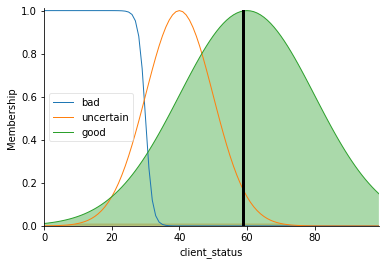

In [ ]:
client_status.view(sim=simulation)

**The test result tells that it's a good client, as expected.**